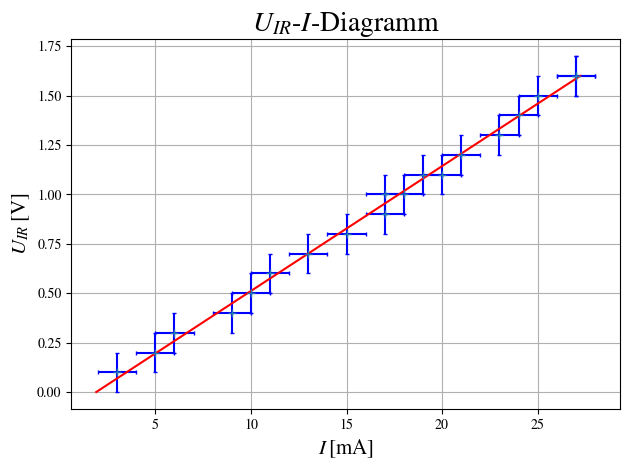

R=  63.20454925572839 +/- 4.575618874932944 b=  1.9097644879597793 +/- 0.22270855459789232
R_X  =  64.8439215901603 +/- 5.297690513507587


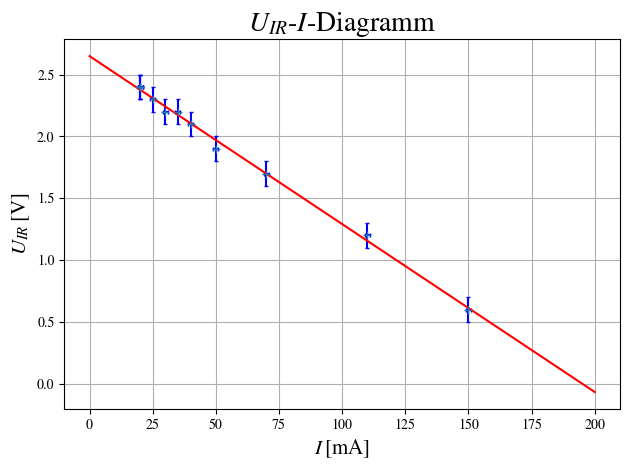

R=  13.568004037345466 +/- 0.4046731157100905 b=  2.648523845571537 +/- 0.16247051791019682


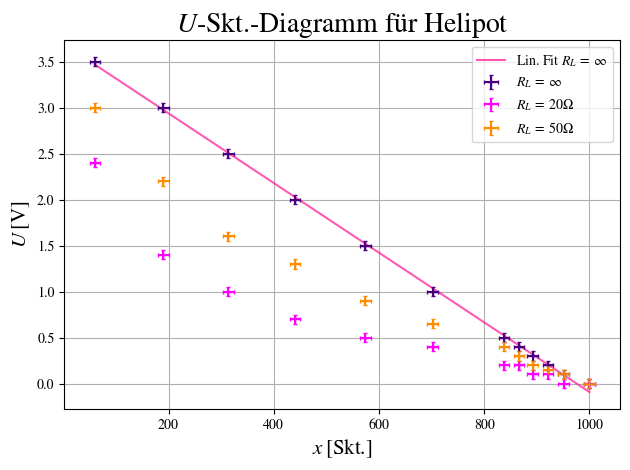

m=  -0.003788615722027563 +/- 0.0003227406745045573 b=  3.6961828845224636 +/- 0.23113509283337577
U_b =  3.17207031250000  +/-  0.013182587529565972
sqrt(R_2**2*x**2*Δx_max**2/(-x + x_max)**4 + x**2*ΔR_2**2/(-x + x_max)**2 + Δx**2*(R_2*x/(-x + x_max)**2 + R_2/(-x + x_max))**2)
R_1=  66.8224299065421  +/-  0.18349701266863375
NTP-Widerstand : m=  3773.7818545958858 +/- 372.2885292209367 b=  -5.767542757772025 +/- 1.125752588998683


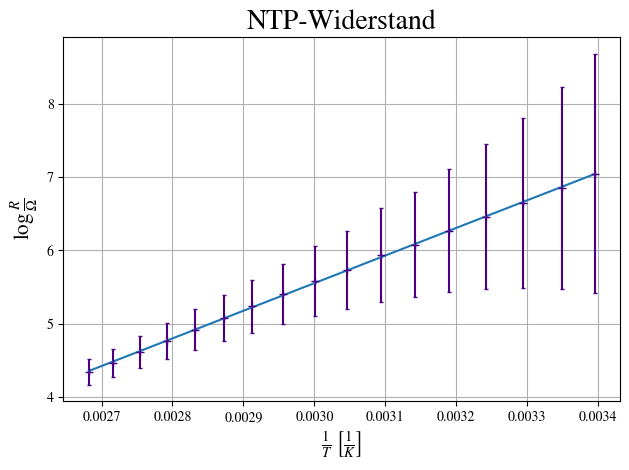

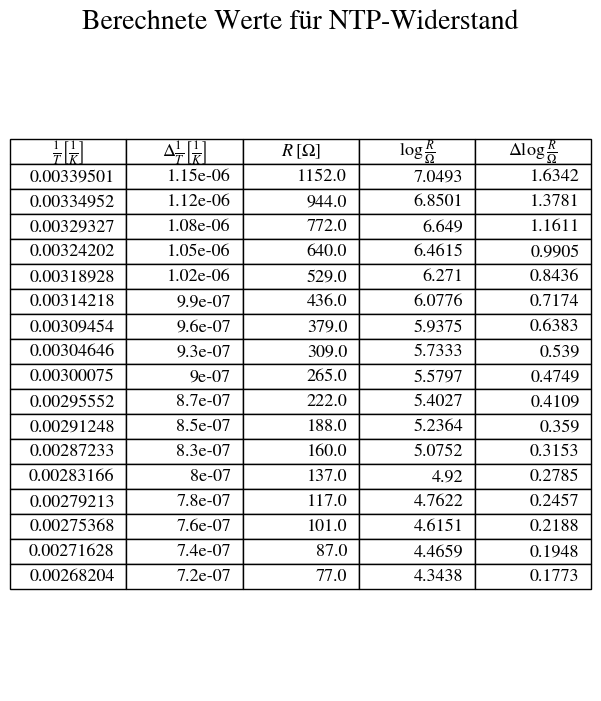

Konstantan-Widerstand : m=  -0.0001583302769577175 +/- 0.0004174187585067235 b=  4.180119717966971 +/- 0.027087384348894884
Konstantan-Widerstand : Alpha=  -3.78769718669021e-5  +/-  69603.97640230253


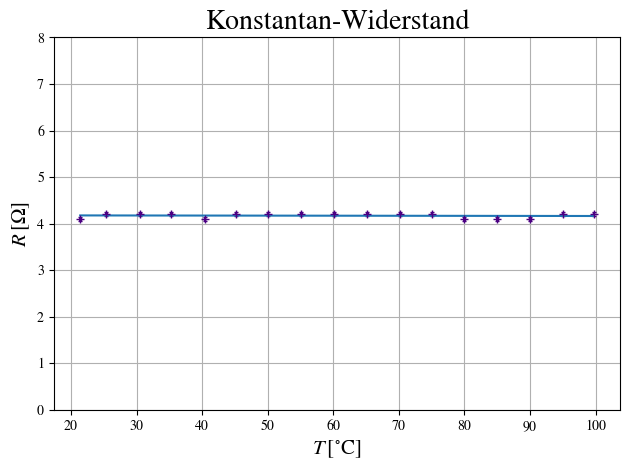

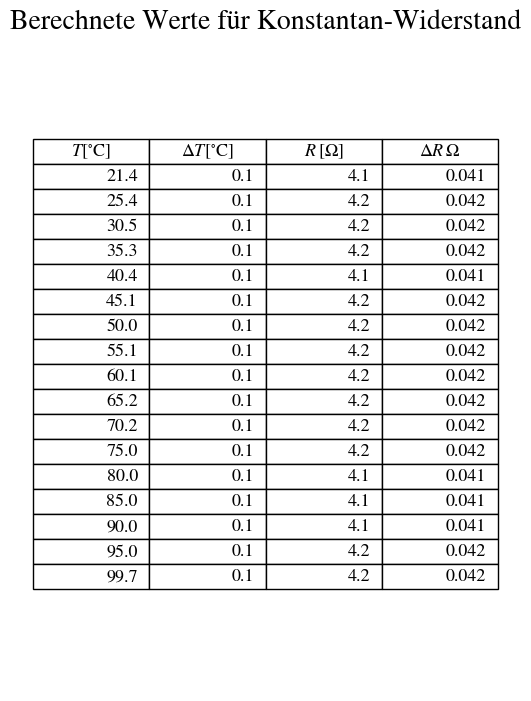

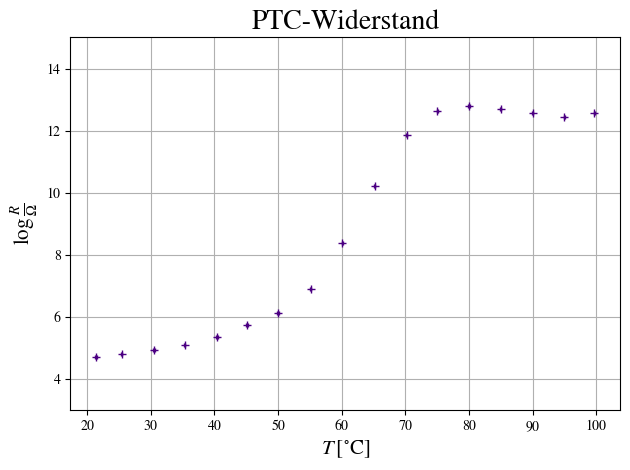

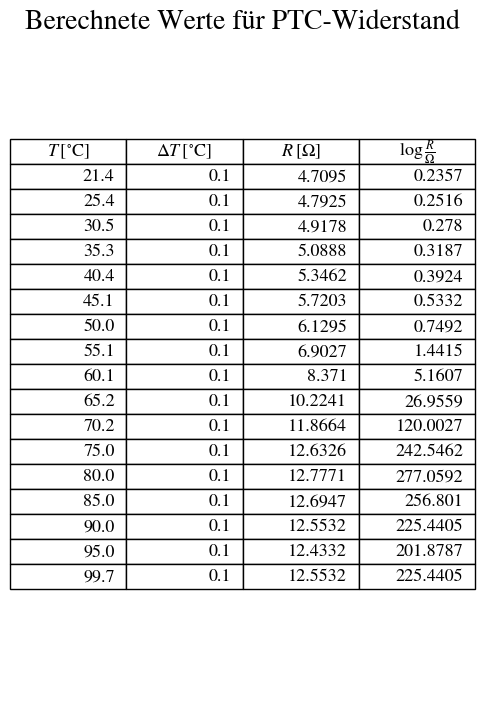

Platin-Widerstand : m=  3.663562190729862 +/- 0.12184314196979183 b=  1006.2770855298272 +/- 7.906717054642277
Platin-Widerstand : Alpha=  0.00364070914801853  +/-  9.386544593055415


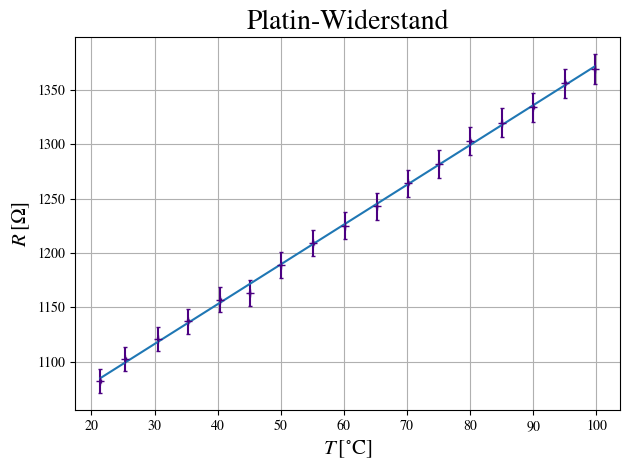

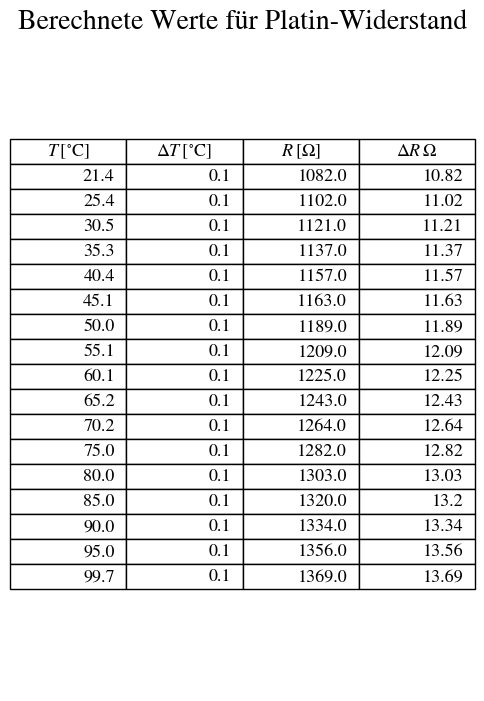

Kohleschichtwiderstand : m=  -0.0008547830774990087 +/- 0.010035172547230756 b=  100.29851676479483 +/- 0.6512083375619057
Kohleschichtwiderstand : Alpha=  -8.52239001204294e-6  +/-  1377550.6942252247


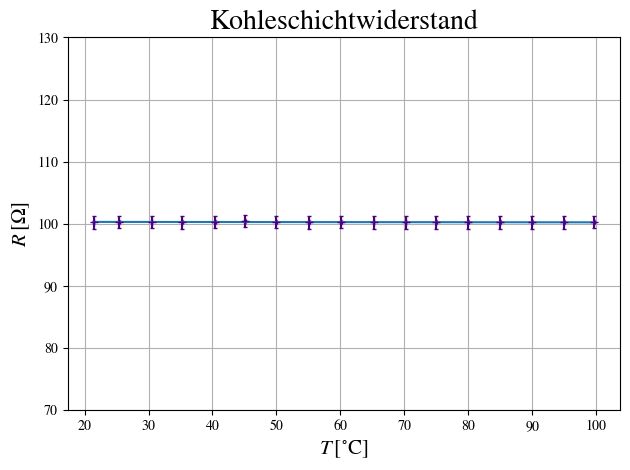

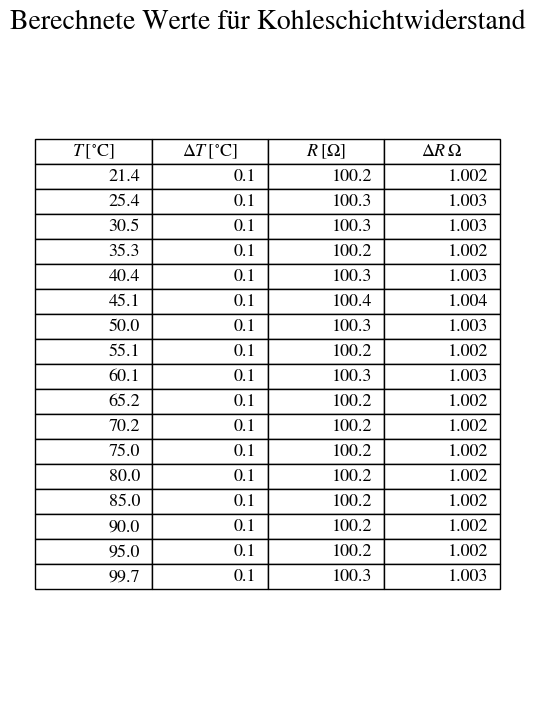

In [6]:
import sympy as sp
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tabulate import tabulate
from sympy import init_printing

import os
from os import listdir
from os.path import isfile, join

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

def calcErr(f: sp.Expr, values: List[float], errorL: List[float]) -> Tuple[sp.Function, float]:
    """
    Calculate error using Gaussian error propagation.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error needs to be calculated
    values : List[float]
        List of values for each variable in the function
    errorL : List[float]
        List of uncertainties for each variable in the function
        
    Returns:
    --------
    Tuple[sp.Function, float]
        - Symbolic error propagation function
        - Numerical result of error calculation
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    if not (len(vars) == len(errorL) == len(values)):
        raise ValueError("Number of values and errors must match number of variables in function")
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    
    error_func = error_func.subs(error_func, error_expr)
    
    # Print the symbolic error propagation function
    # print("\nSymbolic error propagation function:")
    # print(f"{error_func.simplify()}")
    
    # Calculate numerical result using the provided values
    numerical_error = error_expr.subs(dict(zip(error_symbols, errorL)))
    result = float(numerical_error.evalf(subs=dict(zip(vars, values))))
    

    return result

def find_error_func(f: sp.Expr) -> sp.Function:
    """
    Creates symbolic error propagation function for given function f.
    
    Parameters:
    -----------
    f : sympy.Expr
        Symbolic function for which error propagation function is needed
        
    Returns:
    --------
    sp.Function
        Symbolic error propagation function
    """
    # Get variables in the function
    vars = list(f.free_symbols)
    
    # Create symbolic error variables
    error_symbols = [sp.Symbol(f'Δ{var}') for var in vars]
    
    # Create symbolic error propagation function
    error_expr = sp.sqrt(sum((sp.diff(f, var) * err)**2 
                           for var, err in zip(vars, error_symbols)))
    
    # Convert to sp.Function
    error_func = sp.Function('σ')(*error_symbols)
    error_func = error_func.subs(error_func, error_expr)
    
    return error_func

def plot_table(columns, col_names, filename, title):
    """
    Plots a table from a list of numpy arrays (columns) and saves it as a PNG file.
    
    Parameters:
    columns (list of numpy.ndarray): The data to be plotted in the table, where each element is a column.
    col_names (list of str): The names of the columns.
    filename (str, optional): The name of the output PNG file.
    """
    # Get the maximum number of rows
    max_rows = max(len(col) for col in columns)
    
    # Create a 2D numpy array to hold the data
    data = np.full((max_rows, len(columns)), np.nan)
    
    # Fill the data array with the input columns
    for i, col in enumerate(columns):
        data[:len(col), i] = col
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(len(columns) * 1.5, max_rows * 0.5))
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    the_table = ax.table(cellText=data.astype(str),
                        colLabels=col_names,
                        loc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(13)
    the_table.scale(1, 1.5)
    # Save the figure
    
    plt.title(title, fontsize=20)
    plt.savefig(filename, dpi=300)
    plt.show()

def fit_error(x, y_err):

    sigma = len(x) / (np.sum(1/(y_err**2)))

    xsquaremean = np.average(x**2)
    xmean = np.average(x)
    yerrsquaremean = np.average(sigma)

    m_err = np.sqrt(yerrsquaremean / (len(x)*(xsquaremean - xmean**2)))
    n_err = np.sqrt((yerrsquaremean * xsquaremean) / (len(x) * (xsquaremean - xmean**2)))

    return m_err, n_err

def ab():
    source = "Data/232a.csv"
    data = np.genfromtxt(source, delimiter=' ')
    voltage = data[:,1]
    amps = data[:,2]
    m, b = np.polyfit(voltage, amps, 1)

    

    x = np.linspace(0, np.max(voltage), 100)

    # Calculation

    x_errs = np.full(len(amps), 1)
    y_errs = np.full(len(voltage), 0.1)


    plt.errorbar(amps, voltage, marker='+', xerr=x_errs, yerr=y_errs, ls=' ', capsize=1.5, ecolor='blue')
    plt.plot(m*x + b, x, color='red')
    plt.ylabel(r'$U_{IR} \: \left[ \text{V} \right]$', fontsize=15)
    plt.xlabel(r'$I \: \left[ \text{mA} \right]$', fontsize=15)
    plt.title(r"$U_{IR}$-$I$-Diagramm", fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.savefig("Figures/232a.pdf",  format="pdf", dpi=600)
    plt.show()

    m_si = m
    b_si = b

    m_err, b_err = fit_error(voltage, 0.1)
    
    print("R= ", 1000/m_si, "+/-", 1/m_err, "b= ", b_si, "+/-", b_err)



    R_U, R_A = sp.symbols('R_U R_A')
    R_X = (R_A * R_U) / (R_U - R_A)

    values = [2500, 1000/m_si]
    errors = [2500 * 0.01, 1.1/m_err]
    R_X_err = calcErr(R_X, values, errors)
    print("R_X  = ", R_X.evalf(subs={R_U:values[0], R_A:values[1]}) , "+/-", R_X_err)

def d():
    source = "Data/232d.csv"
    data = np.genfromtxt(source, delimiter=' ')
    voltage = data[:,2]
    amps = data[:,1]
    
    m, b = np.polyfit(amps, voltage, 1)
    
    R_Amp500 = 0.4
    R_Volt5 = 2500
    
    x = np.linspace(0, 200, 1000)

    # Calculation

    x_errs = np.full(len(amps), 1)
    y_errs = np.full(len(voltage), 0.1)


    plt.errorbar(amps, voltage, marker='+', xerr=x_errs, yerr=y_errs, ls=' ', capsize=1.5, ecolor='blue')
    plt.plot(x, m*x + b, color='red')
    plt.ylabel(r'$U_{IR} \: \left[ \text{V} \right]$', fontsize=15)
    plt.xlabel(r'$I \: \left[ \text{mA} \right]$', fontsize=15)
    plt.title(r"$U_{IR}$-$I$-Diagramm", fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.savefig("Figures/232d.pdf",  format="pdf", dpi=600)
    plt.show()
    
    m_si = m*1000
    b_si = b

    m_err, b_err = fit_error(amps/1000, 0.1)
    
    print("R= ", np.abs(m_si), "+/-", 1/m_err, "b= ", b_si, "+/-", b_err)

def f():
    source = "Data/232f.csv"
    data = np.genfromtxt(source, delimiter=' ')
    v_Rinf = data[:,1]
    v_R20 = data[:,2]
    v_R50 = data[:,3]
    x_skt = data[:,0]
    
    m, b = np.polyfit(x_skt, v_Rinf, 1)
    
    # Calculation
    y_errs = np.full(len(v_Rinf), 0.05)
    x_errs = np.full(len(x_skt), 10)
    plt.plot(x_skt, m*x_skt + b, color='deeppink', alpha=0.7, label=r'Lin. Fit $R_L \: = \: \infty$')
    
    plt.errorbar(x_skt, v_Rinf, marker='+', yerr=y_errs, xerr=x_errs, ls=' ', capsize=1.5, ecolor='indigo', color='indigo', label=r'$R_L \: = \: \infty$')
    plt.errorbar(x_skt, v_R20, marker='+', yerr=y_errs, xerr=x_errs, ls=' ', capsize=1.5, ecolor='fuchsia', color='fuchsia', label=r'$R_L \: = \: 20 \Omega$')
    plt.errorbar(x_skt, v_R50, marker='+', yerr=y_errs, xerr=x_errs, ls=' ', capsize=1.5, ecolor='darkorange', color='darkorange', label=r'$R_L \: = \: 50 \Omega$')
    
    plt.ylabel(r'$U \: \left[ \text{V} \right]$', fontsize=15)
    plt.xlabel(r'$x \: \left[ \text{Skt.} \right]$', fontsize=15)
    plt.title(r"$U$-Skt.-Diagramm für Helipot", fontsize=20)
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig("Figures/232f.pdf",  format="pdf", dpi=600)
    plt.show()
    
    m_si = m        # Volt / Skt.
    b_si = b        # Volt

    m_err, b_err = fit_error(x_skt, 0.1)
    
    print("m= ", m_si, "+/-", m_err, "b= ", b_si, "+/-", b_err)

def h():

    # Spannung der Batterie U_b berechnen

    x_b, x_w, U_w = sp.symbols('x_b x_w U_w')
    values = [100-25.5, 100-74.4, 1.090]
    errors = [0.1, 0.1, 0.0005]

    U_b = (x_b / x_w) * U_w

    U_b_err = calcErr(U_b, values, errors)
    U_b_val = U_b.evalf(subs={x_b:values[0], x_w:values[1], U_w:values[2]})

    print("U_b = ", U_b_val, " +/- ", U_b_err)

def j():
    R_2, x, x_max = sp.symbols('R_2 x, x_max')
    R_1 = (x * R_2) / (x_max - x)
    values = [50, 572, 1000]
    errors = [0, 1, 0]

    R_1_err = calcErr(R_1, values, errors)
    R_1_val = R_1.evalf(subs={R_2:values[0], x:values[1], x_max:values[2]})

    print(find_error_func(R_1))
    print("R_1= ", R_1_val, " +/- ", R_1_err) 

def lm():
    
    source = "Data/232l.csv"
    data = np.genfromtxt(source, delimiter=' ')
    
    T = data[:,0] + 273.15
    R_1 = data[:,1]
    R_2 = data[:,2]
    R_3 = data[:,3]
    R_4 = data[:,4]
    R_5 = data[:,5]

    R_array = [R_1, R_2, R_3, R_4, R_5]
    R_errs = [0] * len(R_array)
    T_err = np.full(len(T), 0.1)
    
    names = [r"NTP-Widerstand", r"Konstantan-Widerstand", r"PTC-Widerstand", r"Platin-Widerstand", r"Kohleschichtwiderstand"]
    
    
    for i in range(len(R_array)):     # Wie macht man reference Loops in Python lol??
        R_errs[i] = R_array[i] * 0.01     # Fehler VC830

    # NTP
    # log(R/Omega) 1/T
    
    index = 0
    
    R_trans = np.log(R_array[index])
    T_trans = 1/T
    R_err_trans = R_errs[index] / (R_trans)
    T_err_trans = T_err/(T**2)

    m, b = np.polyfit(T_trans, R_trans, 1)
    
    m_err, b_err = fit_error(T_trans, R_err_trans)
    
    print(names[index], ": m= ", m, "+/-", m_err, "b= ", b, "+/-", b_err)
    
    plt.errorbar(T_trans, R_trans, marker='+', yerr=np.abs(R_err_trans),  ls=' ', capsize=1.5, ecolor='indigo', color='indigo')
    plt.plot(T_trans, m*T_trans + b)
    plt.title(names[index], fontsize=20)
    plt.grid()
    plt.xlabel(r'$\frac{1}{T} \: \left[ \frac{1}{K} \right]$', fontsize=15)
    plt.ylabel(r'$\log{\frac{R}{\Omega}}$', fontsize=15)
    plt.tight_layout()
    plt.savefig("Figures/232l" + names[index] + ".pdf",  format="pdf", dpi=600)
    plt.show()
    
    tabledata = [np.round(T_trans, 8), np.round(T_err_trans, 8), np.round(R_array[index], 4), np.round(R_trans, 4), np.round(R_err_trans, 4)]
    col_names = [r"$\frac{1}{T} \left[ \frac{1}{K} \right]$", r"$ \Delta \frac{1}{T} \left[ \frac{1}{K} \right]$", r'$R \: \left[ \Omega \right]$', r'$\log{\frac{R}{\Omega}}$', r'$\Delta \log{\frac{R}{\Omega}}$']
    
    plot_table(tabledata, col_names, "Figures/" + names[index] + "table.pdf", "Berechnete Werte für " + names[index])
    
    # Konstantan
    # Linear
    
    index = 1
    
    R_trans = R_array[index]
    T_trans = T - 273.15
    R_err_trans = R_errs[index]
    T_err_trans = np.full(len(T_trans), 0.1)

    m, b = np.polyfit(T_trans, R_trans, 1)
    
    m_err, b_err = fit_error(T_trans, R_err_trans)
    print(names[index], ": m= ", m, "+/-", m_err, "b= ", b, "+/-", b_err)

    m_sp, b_sp = sp.symbols("m b")
    values = [m, b]
    errors = [m_err, b_err]

    alpha = m_sp/b_sp

    alpha_err = calcErr(alpha, values, errors)
    alpha_val = alpha.evalf(subs={m_sp:values[0], b_sp:values[1]})
    
    print(names[index], ": Alpha= ", alpha_val, " +/- ", alpha_err)
    
    plt.errorbar(T_trans, R_trans, marker='+', yerr=np.abs(R_err_trans), xerr=T_err, ls=' ', capsize=1.5, ecolor='indigo', color='indigo')
    plt.plot(T_trans, m*T_trans + b)
    plt.title(names[index], fontsize=20)
    plt.grid()
    plt.xlabel(r'$T \: \left[ ^{\circ} \text{C} \right]$', fontsize=15)
    plt.ylabel(r'$R \: \left[ \Omega \right]$', fontsize=15)
    plt.ylim([0, 8])
    plt.tight_layout()
    plt.savefig("Figures/232l" + names[index] + ".pdf",  format="pdf", dpi=600)
    plt.show()
    
    tabledata = [np.round(T_trans, 4), np.round(T_err_trans, 4), np.round(R_array[index], 4), np.round(R_err_trans, 4)]
    col_names = [r"$T \left[ ^{\circ} \text{C} \right]$", r"$ \Delta T \left[ ^{\circ} \text{C} \right]$", r'$R \: \left[ \Omega \right]$', r'$\Delta R \:{\Omega}$']
    
    plot_table(tabledata, col_names, "Figures/" + names[index] + "table.pdf", "Berechnete Werte für " + names[index])

    # PTC
    # log(R/Omega)
    
    index = 2
    
    R_trans = np.log(R_array[index])
    T_trans = T - 273.15
    R_err_trans = R_errs[index] / (R_trans)
    T_err_trans = np.full(len(T_trans), 0.1)


    plt.errorbar(T_trans, R_trans, marker='+', xerr=T_err, ls=' ', capsize=1.5, ecolor='indigo', color='indigo')
    plt.title(names[index], fontsize=20)
    plt.grid()
    plt.xlabel(r'$T \: \left[ ^{\circ} \text{C} \right]$', fontsize=15)
    plt.ylabel(r'$\log{\frac{R}{\Omega}}$', fontsize=15)
    plt.ylim([3, 15])
    plt.tight_layout()
    plt.savefig("Figures/232l" + names[index] + ".pdf",  format="pdf", dpi=600)
    plt.show()
    
    tabledata = [np.round(T_trans, 4), np.round(T_err_trans, 4), np.round(R_trans, 4), np.round(R_err_trans, 4)]
    col_names = [r"$T \: \left[ ^{\circ} \text{C} \right]$", r"$ \Delta T \: \left[ ^{\circ} \text{C} \right]$", r'$R \: \left[ \Omega \right]$', r'$\log{\frac{R}{\Omega}}$']
    
    plot_table(tabledata, col_names, "Figures/" + names[index] + "table.pdf", "Berechnete Werte für " + names[index])
    
    # Platin
    # Linear
    
    index = 3
    
    R_trans = R_array[index]
    T_trans = T - 273.15
    R_err_trans = (R_errs[index])
    T_err_trans = np.full(len(T_trans), 0.1)


    m, b = np.polyfit(T_trans, R_trans, 1)
    
    m_err, b_err = fit_error(T_trans, R_err_trans)
    
    print(names[index], ": m= ", m, "+/-", m_err, "b= ", b, "+/-", b_err)
    
    m_sp, b_sp = sp.symbols("m b")
    values = [m, b]
    errors = [m_err, b_err]

    alpha = m_sp/b_sp

    alpha_err = calcErr(alpha, values, errors)
    alpha_val = alpha.evalf(subs={m_sp:values[0], b_sp:values[1]})

    print(names[index], ": Alpha= ", alpha_val, " +/- ", alpha_err)

    plt.errorbar(T_trans, R_trans, marker='+', yerr=np.abs(R_err_trans), xerr=T_err, ls=' ', capsize=1.5, ecolor='indigo', color='indigo')    
    plt.plot(T_trans, m*T_trans + b)
    plt.title(names[index], fontsize=20)
    plt.grid()
    plt.xlabel(r'$T \: \left[ ^{\circ} \text{C} \right]$', fontsize=15)
    plt.ylabel(r'$R \: \left[ \Omega \right]$', fontsize=15)
    plt.tight_layout()
    plt.savefig("Figures/232l" + names[index] + ".pdf",  format="pdf", dpi=600)
    plt.show()
    
    tabledata = [np.round(T_trans, 4), np.round(T_err_trans, 4), np.round(R_array[index], 4), np.round(R_err_trans, 4)]
    col_names = [r"$T \: \left[  ^{\circ} \text{C} \right]$", r"$ \Delta T \: \left[ ^{\circ} \text{C} \right]$", r'$R \: \left[ \Omega \right]$', r'$\Delta R \:{\Omega}$']
    
    plot_table(tabledata, col_names, "Figures/" + names[index] + "table.pdf", "Berechnete Werte für " + names[index])
    
    # Kohleschicht
    # Linear
    
    index = 4
    
    R_trans = R_array[index]
    T_trans = T - 273.15
    R_err_trans = R_errs[index]

    m, b = np.polyfit(T_trans, R_trans, 1)
    
    m_err, b_err = fit_error(T_trans, R_err_trans)
    
    print(names[index], ": m= ", m, "+/-", m_err, "b= ", b, "+/-", b_err)
    
    m_sp, b_sp = sp.symbols("m b")
    values = [m, b]
    errors = [m_err, b_err]

    alpha = m_sp/b_sp

    alpha_err = calcErr(alpha, values, errors)
    alpha_val = alpha.evalf(subs={m_sp:values[0], b_sp:values[1]})

    print(names[index], ": Alpha= ", alpha_val, " +/- ", alpha_err)

    plt.errorbar(T_trans, R_trans, marker='+', yerr=np.abs(R_err_trans), xerr=T_err, ls=' ', capsize=1.5, ecolor='indigo', color='indigo')    
    plt.plot(T_trans, m*T_trans + b)
    plt.title(names[index], fontsize=20)
    plt.grid()
    plt.xlabel(r'$T \: \left[ ^{\circ} \text{C} \right]$', fontsize=15)
    plt.ylabel(r'$R \: \left[ \Omega \right]$', fontsize=15)
    plt.ylim([70, 130])
    plt.tight_layout()
    plt.savefig("Figures/232l" + names[index] + ".pdf",  format="pdf", dpi=600)
    plt.show()
    
    tabledata = [np.round(T_trans, 4), np.round(T_err_trans, 4), np.round(R_array[index], 4), np.round(R_err_trans, 4)]
    col_names = [r"$T \: \left[ ^{\circ} \text{C} \right]$", r"$ \Delta T \:  \left[ ^{\circ} \text{C} \right]$", r'$R \: \left[ \Omega \right]$', r'$\Delta R \:{\Omega}$']
    
    plot_table(tabledata, col_names, "Figures/" + names[index] + "table.pdf", "Berechnete Werte für " + names[index])
    
init_printing()

ab()
d()
f()
h()
j()
lm()